In [ ]:
# SAM + Hierarchical Clustering + CutMix + Local Representation Training + Feature Selection via Regularization

In [1]:
import random
import logging
from pathlib import Path, PurePath
from typing import Literal

import IPython.display as display
from tqdm.notebook import tqdm, trange
import numpy as np
import torch
from PIL import Image
from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.pyplot as plt
from transformers import pipeline

device = "cuda:2"

logger = logging.getLogger(__name__)

random.seed(42)

BATCH_SIZE = 256

In [5]:
from exrep.utils import Embedder

embedder = pipeline("image-feature-extraction", 
    model="facebook/dino-vits16", framework="pt", device=device, 
    batch_size=128, return_tensors=True, pool=True
)

def load_local_data(input_path, neighborhood_path):
    img_to_explain = Image.open(input_path)
    images = [Image.open(p) for p in Path(neighborhood_path).glob("*.jpg")]
    embeddings = torch.cat(embedder(images), dim=0)
    return img_to_explain, images, embeddings

img_to_explain, images, embeddings = load_local_data(
    input_path="../data/queries/ILSVRC2012_val_00000339.JPEG",
    neighborhood_path="../data/retrieved/00000339_digital watch",
)

# load the local neigborhood dataset
# data_path = Path("../data/retrieved/00000590_Samoyed")
# img_to_explain = Image.open("../data/queries/ILSVRC2012_val_00000590.JPEG")
# data_path = Path("../data/retrieved/00000369_military aircraft")
# img_to_explain = Image.open("../data/queries/ILSVRC2012_val_00000369.JPEG")

print(f"Loaded {len(images)} images")
print("Embeddings shape:", embeddings.shape)

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0


Loaded 1000 images
Embeddings shape: torch.Size([1000, 384])


In [6]:
# Segmentation function returns a numpy array, each pixel with an integral value representing the instance that it belongs to
from exrep.utils import validate_mask_area, get_sam_mask_generator

def mask_to_bbox(mask):
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    # left, upper, right, lower
    return cmin, rmin, cmax, rmax

# segment function that behaves similarly to quickshift
def sam_segment_fn(image: Image.Image, generator, mask_validator=validate_mask_area, **kwargs):
    masks = generator([image], **kwargs)[0]
    # sort in ascending order of area
    masks.sort(key=lambda mask: mask.sum(), reverse=True)
    indexed_masks = np.array(masks) * np.arange(1, len(masks) + 1)[:, None, None]
    # heuristic: choose masks in descending order of area until the entire image is covered
    segments = indexed_masks.max(axis=0)
    invalid_segments = [
        segment for segment in np.unique(segments)
        if not mask_validator(image, segments == segment)
    ]
    for segment in invalid_segments:
        segments[segments == segment] = 0
    return segments

Device set to use cuda:0


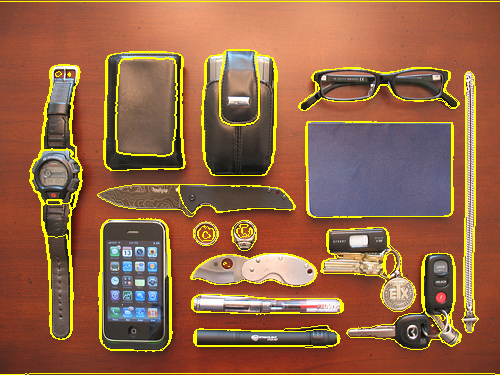

In [7]:
from skimage.segmentation import mark_boundaries

sam_mask_generator = get_sam_mask_generator(points_per_batch=128, device=device)
input_segments = sam_segment_fn(img_to_explain, sam_mask_generator)
img_viz = mark_boundaries(np.array(img_to_explain), input_segments)

# cache the fudged image for enhanced performance  
fudged_image = np.array(img_to_explain)
for segment in np.unique(input_segments):
    mask = input_segments == segment    
    fudged_image[mask] = np.mean(fudged_image[mask], axis=0)

Image.fromarray((img_viz * 255).astype(np.uint8))

In [12]:
%load_ext autoreload
%autoreload 2
from exrep.explain import LocalFeatureManager

# segment 0 is the background in input_segments
binary_masks = np.array([input_segments == segment for segment in np.unique(input_segments)])
segmented_images = np.array(img_to_explain)[None, :] * binary_masks[..., None]

# the first image & mask correspond to the background segment, so we replace it with the fudged image
binary_masks[0] = 1
segmented_images[0] = fudged_image

trait_manager = LocalFeatureManager(img_to_explain, input_segments, return_format="PIL")
trait_manager.fit(
    choices_per_feature={segment: [0, i + 1] for i, segment in enumerate(np.unique(input_segments)[1:])},
    replacements=torch.tensor(segmented_images),
    binary_masks=torch.tensor(binary_masks),
)
binary_traits, binary_sampled_images = trait_manager.sample_data(num_samples=10000)
binary_sample_embeddings = torch.cat(embedder(binary_sampled_images), dim=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


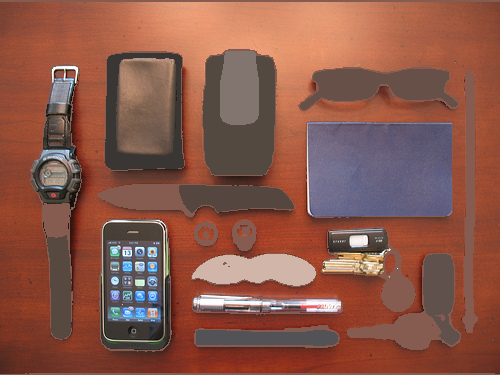

In [16]:
binary_sampled_images[2]

In [17]:
from sklearn.model_selection import train_test_split

# split the dataset into train and validation sets
query_inputs_train, query_inputs_val, query_targets_train, query_targets_val = train_test_split(
    binary_traits, binary_sample_embeddings, test_size=0.1, random_state=42, shuffle=False
)

print("Train set shape:", query_inputs_train.shape, query_targets_train.shape)
print("Val set shape:", query_inputs_val.shape, query_targets_val.shape)

Train set shape: torch.Size([9000, 17]) torch.Size([9000, 384])
Val set shape: torch.Size([1000, 17]) torch.Size([1000, 384])


In [46]:
%load_ext autoreload
%autoreload 2
from exrep.train import train_local_representation

model_config = dict(
    output_dim=16,
    # this temperature is for inference only!
    temperature=0.21,
    # use_key_encoder=False,
)
loss_config = dict(
    gamma1=1.0,
    gamma2=1.0,
    temp_student=0.21,
    temp_teacher=0.07,
)
optimizer_config = dict(
    lr=1e-3,
    weight_decay=1e-2,
)

keys = embeddings[:1000]

model, logs = train_local_representation(
    model_config=model_config,
    loss_config=loss_config,
    optimizer_config=optimizer_config,
    query_inputs_train=query_inputs_train,
    query_targets_train=query_targets_train,
    query_inputs_val=query_inputs_val,
    query_targets_val=query_targets_val,
    keys=keys.clone(),
    groups=[(i, ) for i in range(query_inputs_train.shape[1])],
    alpha=0,
    num_epochs=20,
    batch_size=512,
    device=device,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


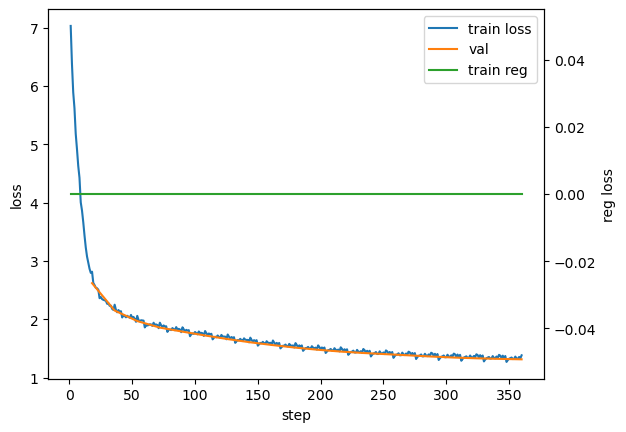

In [47]:
fig, ax = plt.subplots()

twin1 = ax.twinx()

p1, = ax.plot([log["step"] for log in logs["train"]], [log["loss"] for log in logs["train"]], 'C0', label="train loss")
p3, = twin1.plot([log["step"] for log in logs["train"]], [log["loss_reg"] for log in logs["train"]], 'C2', label="train reg")
p2, = ax.plot([log["step"] for log in logs["val"]], [log["val_loss"] for log in logs["val"]], 'C1', label="val")
# p4, = ax.plot([log["step"] for log in logs["train"]], [log["grad_estimator"] for log in logs["train"]], 'C3', label="train total loss")

ax.set_ylabel("loss")
ax.set_xlabel("step")
# ax.set_ylim([0, 1])
twin1.set_ylabel("reg loss")
ax.legend(handles=[p1, p2, p3])

In [285]:
%load_ext autoreload
%autoreload 2
from exrep.train import regularization_path

model_config = dict(
    output_dim=8,
    # this temperature is for inference only!
    temperature=0.21,
)
loss_config = dict(
    gamma1=1.0,
    gamma2=1.0,
    temp_student=0.21,
    temp_teacher=0.21,
)
optimizer_config = dict(
    lr=1e-3,
    weight_decay=1e-2,
)

keys = torch.concat((embeddings[:1000], query_targets_train, query_targets_val), dim=0)

alphas = np.logspace(-3, 0, num=20)

alpha_logs, raw_logs = regularization_path(
    alphas=alphas,
    repeat_per_alpha=10,
    model_config=model_config,
    loss_config=loss_config,
    optimizer_config=optimizer_config,
    query_inputs_train=query_inputs_train,
    query_targets_train=query_targets_train,
    query_inputs_val=query_inputs_val,
    query_targets_val=query_targets_val,
    keys=keys.clone(),
    groups=[(i, ) for i in range(query_inputs_train.shape[1])],
    num_epochs=20,
    batch_size=512,
    device=device,
)

2025-01-27 18:27:48 - INFO - Training with alpha = 0.001


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2025-01-27 18:28:25 - INFO - Training with alpha = 0.0014384498882876629
2025-01-27 18:28:59 - INFO - Training with alpha = 0.00206913808111479
2025-01-27 18:29:35 - INFO - Training with alpha = 0.002976351441631319
2025-01-27 18:30:14 - INFO - Training with alpha = 0.004281332398719396
2025-01-27 18:30:49 - INFO - Training with alpha = 0.006158482110660267
2025-01-27 18:31:24 - INFO - Training with alpha = 0.008858667904100823
2025-01-27 18:31:59 - INFO - Training with alpha = 0.012742749857031334
2025-01-27 18:32:34 - INFO - Training with alpha = 0.018329807108324356
2025-01-27 18:33:10 - INFO - Training with alpha = 0.026366508987303583
2025-01-27 18:33:46 - INFO - Training with alpha = 0.0379269019073225
2025-01-27 18:34:25 - INFO - Training with alpha = 0.05455594781168517
2025-01-27 18:35:03 - INFO - Training with alpha = 0.07847599703514611
2025-01-27 18:35:41 - INFO - Training with alpha = 0.11288378916846883
2025-01-27 18:36:19 - INFO - Training with alpha = 0.1623776739188721

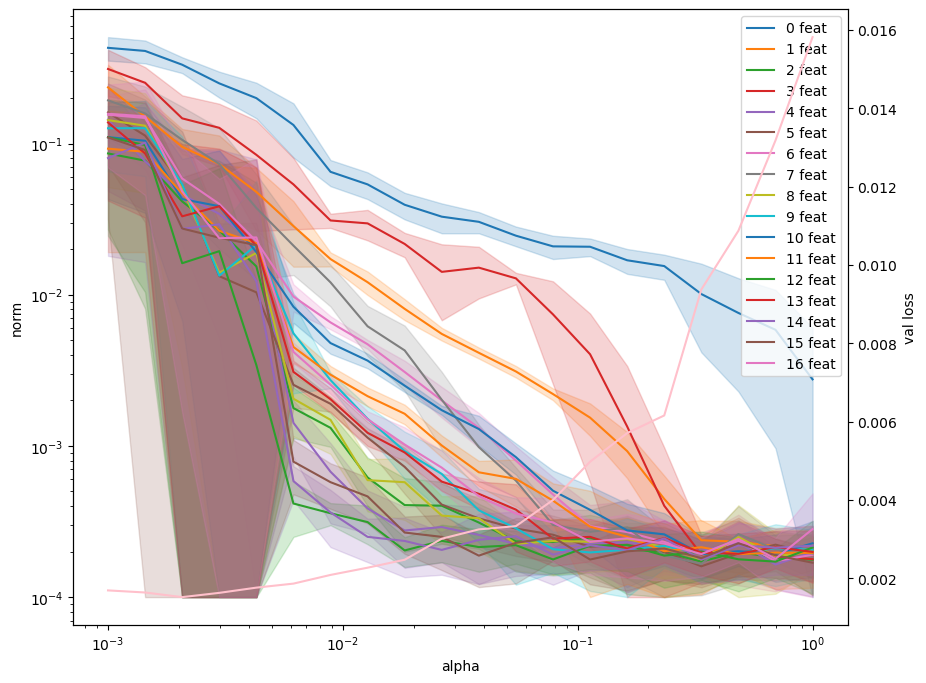

In [286]:
num_binary_features = alpha_logs[0]["mean_weights"].shape[0]

fig, ax = plt.subplots(figsize=(10, 8))
twin1 = ax.twinx()

handles = []
for i in range(num_binary_features):
    p = ax.plot(alphas, [log["mean_weights"][i] for log in alpha_logs], label=f"{i} feat")[0]
    ax.fill_between(alphas, 
        [max(0.0001, log["mean_weights"][i] - log["std_weights"][i]) for log in alpha_logs], 
        [log["mean_weights"][i] + log["std_weights"][i] for log in alpha_logs], 
        alpha=0.2, color=p.get_color()
    )
    handles.append(p)

twin1.plot(alphas, [log["mean_val_loss"] for log in alpha_logs], "pink", label="val reg")

ax.set_ylabel("norm")
ax.set_xlabel("alpha")
ax.set_xscale("log")
ax.set_yscale("log")
twin1.set_ylabel("val loss")

ax.legend(handles=handles)

In [274]:
%load_ext autoreload
%autoreload 2
from exrep.train import train_local_representation

model_binary, logs = train_local_representation(
    model_config=model_config,
    loss_config=loss_config,
    optimizer_config=optimizer_config,
    query_inputs_train=query_inputs_train,
    query_targets_train=query_targets_train,
    query_inputs_val=query_inputs_val,
    query_targets_val=query_targets_val,
    keys=keys.clone(),
    groups=[(i, ) for i in range(query_inputs_train.shape[1])],
    alpha=0.01,
    num_epochs=20,
    batch_size=512,
    log_every_n_steps=20,
    device=device,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2025-01-27 17:42:45 - INFO - Epoch  1, Step   20, Loss: 1.06208
2025-01-27 17:42:45 - INFO - Epoch  2, Step   40, Loss: 1.05566
2025-01-27 17:42:45 - INFO - Epoch  3, Step   60, Loss: 1.04896
2025-01-27 17:42:45 - INFO - Epoch  4, Step   80, Loss: 1.04220
2025-01-27 17:42:46 - INFO - Epoch  5, Step  100, Loss: 1.03548
2025-01-27 17:42:46 - INFO - Epoch  6, Step  120, Loss: 1.02886
2025-01-27 17:42:46 - INFO - Epoch  7, Step  140, Loss: 1.02238
2025-01-27 17:42:46 - INFO - Epoch  8, Step  160, Loss: 1.01612
2025-01-27 17:42:46 - INFO - Epoch  9, Step  180, Loss: 1.01020
2025-01-27 17:42:47 - INFO - Epoch 11, Step  200, Loss: 1.00570
2025-01-27 17:42:47 - INFO - Epoch 12, Step  220, Loss: 1.00242
2025-01-27 17:42:47 - INFO - Epoch 13, Step  240, Loss: 1.00091
2025-01-27 17:42:47 - INFO - Epoch 14, Step  260, Loss: 1.00063
2025-01-27 17:42:47 - INFO - Epoch 15, Step  280, Loss: 1.00062
2025-01-27 17:42:48 - INFO - Epoch 16, Step  300, Loss: 1.00061
2025-01-27 17:42:48 - INFO - Epoch 17, S

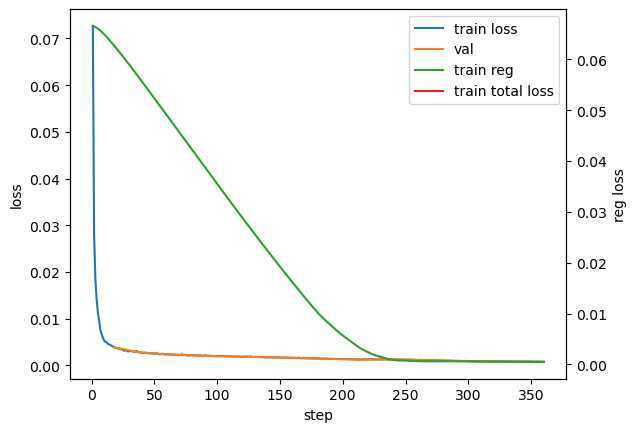

In [275]:
fig, ax = plt.subplots()

twin1 = ax.twinx()

p1, = ax.plot([log["step"] for log in logs["train"]], [log["loss"] for log in logs["train"]], 'C0', label="train loss")
p3, = twin1.plot([log["step"] for log in logs["train"]], [log["loss_reg"] for log in logs["train"]], 'C2', label="train reg")
p2, = ax.plot([log["step"] for log in logs["val"]], [log["val_loss"] for log in logs["val"]], 'C1', label="val")
# p4, = ax.plot([log["step"] for log in logs["train"]], [log["grad_estimator"] for log in logs["train"]], 'C3', label="train total loss")

ax.set_ylabel("loss")
ax.set_xlabel("step")
# ax.set_ylim([0, 1])
twin1.set_ylabel("reg loss")
ax.legend(handles=[p1, p2, p3, p4])

In [276]:
model_binary.query_encoder.weight.norm(p=2, dim=0)

tensor([0.0296, 0.0005, 0.0002, 0.0160, 0.0003, 0.0002, 0.0007, 0.0006, 0.0003,
        0.0003, 0.0002, 0.0004, 0.0002, 0.0003, 0.0004, 0.0003, 0.0002],
       device='cuda:5', grad_fn=<LinalgVectorNormBackward0>)

[3, 1, 7, 6, 10]
[6, 3, 12, 9, 17]


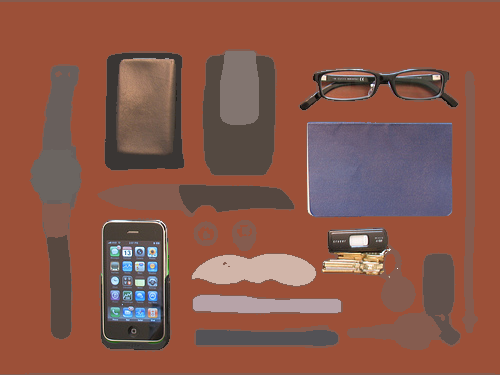

In [290]:
def onehot_dense(elements, num_elements):
    onehot = torch.zeros((len(elements), num_elements))
    onehot[np.arange(len(elements)), elements] = 1
    return onehot

# find the top contributing segments by L2 norm
def get_top_segments(model: torch.nn.Module, k: int):
    weights = model.query_encoder.weight
    norms, top_segments = torch.topk(weights.norm(p=2, dim=0), k=k)
    return onehot_dense(top_segments, weights.shape[1])

# log_to_examine = alpha_logs[len(alpha_logs) // 2]
log_to_examine = [log for log in alpha_logs if abs(log["alpha"] - 0.012) < 1e-3][0]
mean_weights = log_to_examine["mean_weights"]
norms, top_bin_indices = torch.topk(mean_weights, k=6)
top_indices_onehot = onehot_dense(top_bin_indices, mean_weights.shape[0])
top_indices_onehot = top_indices_onehot[1:, ...]        # TODO: remove this
top_ordinals = [x[0] for x in trait_manager.decode(top_indices_onehot, out_level="ordinal")]
top_segments = [x[0] for x in trait_manager.decode(top_indices_onehot, out_level="feature")]
print(top_ordinals)
print(top_segments)

display.display(Image.fromarray(trait_manager.mix(torch.tensor(trait_manager.decode(top_indices_onehot, out_level="categorical").max(axis=0, keepdims=True)))[0]))

In [57]:
def find_similar_crops(crop_embeddings: torch.Tensor, query_embeddings: torch.Tensor, top_k=5):
    similarity_matrix = query_embeddings @ crop_embeddings.T
    distance_matrix, index_matrix = torch.topk(similarity_matrix, top_k, dim=-1, largest=True)
    return distance_matrix, index_matrix

def cluster_crops(crop_embeddings: np.ndarray, n_clusters=5) -> np.ndarray:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(crop_embeddings)
    return kmeans.labels_

def mask_to_crop(image: Image.Image, mask: np.ndarray):
    bbox = mask_to_bbox(mask)
    return image.crop(bbox)

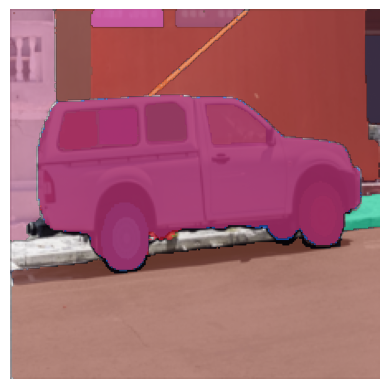

In [43]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from PIL import Image
import requests

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

raw_image = Image.open(requests.get(image_url, stream=True).raw).resize((224, 224))
plt.imshow(np.array(raw_image))
ax = plt.gca()
for mask in outputs["masks"]:
    if mask.sum() > 200:
        show_mask(mask, ax=ax, random_color=True)
plt.axis("off")
plt.show()

In [68]:
# get top segments from inputs
input_crops = [
    mask_to_crop(img_to_explain, input_segments == segment)
    for segment in top_segments
]

# extract crops from images in the local neighborhood and compute their embeddings
max_images = 1000
crops = []

generator = sam_mask_generator
all_masks = generator(images[1:max_images])
for image, masks in zip(images[1:max_images], all_masks):
    for mask in masks:
        bbox = mask_to_bbox(mask)
        crop = image.crop(bbox)
        crops.append(crop)

print(f"Extracted {len(crops)} crops")

In [291]:
import pickle

with open("../outputs/crops_00000339.pkl", "wb") as f:
    pickle.dump(crops, f)

np.save("../outputs/000000339_input-segments.npy", input_segments)

In [ ]:
log_to_examine = alpha_logs[len(alpha_logs) // 2]
mean_weights = log_to_examine["mean_weights"]
norms, top_bin_indices = torch.topk(mean_weights, k=5)
top_indices_onehot = onehot_dense(top_bin_indices, mean_weights.shape[0])
top_indices_onehot = top_indices_onehot[1:, ...]        # TODO: remove this
top_choices = [x[0] for x in trait_manager.decode(top_indices_onehot, out_level="feature", with_choices=True)]
print(top_choices)

In [48]:
query_inputs_batch = query_inputs_train[:100]
query_targets_batch = query_targets_train[:100]
keys_batch = keys[:100]

In [49]:
model(query_inputs_batch.to(device), keys_batch.to(device))

tensor([[1.6339e-10, 1.9155e-09, 2.0314e-10,  ..., 1.4537e-04, 3.2369e-06,
         4.6542e-07],
        [2.9302e-14, 8.3586e-12, 2.3603e-13,  ..., 1.7032e-05, 9.5827e-09,
         5.9657e-10],
        [1.5243e-17, 2.3287e-16, 7.0374e-17,  ..., 4.9711e-07, 3.7523e-11,
         4.4500e-12],
        ...,
        [1.2751e-17, 1.9308e-16, 2.8242e-17,  ..., 1.8003e-07, 3.2298e-11,
         1.6120e-12],
        [8.9720e-17, 2.3044e-16, 1.3220e-16,  ..., 7.3329e-07, 1.3705e-10,
         6.2070e-12],
        [1.1205e-16, 5.7699e-18, 9.7864e-18,  ..., 2.2013e-08, 5.4412e-11,
         1.7900e-12]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [51]:
query_targets_batch.norm(p=2, dim=-1)

tensor([15.4577, 15.5640, 15.7061, 15.5050, 15.3518, 15.7133, 15.3580, 15.4337,
        15.1248, 15.3471, 15.4629, 15.5749, 15.6688, 15.5899, 15.6462, 15.6985,
        15.6388, 15.7547, 15.5851, 15.5460, 15.3554, 15.3074, 15.5315, 15.3747,
        15.4449, 15.4805, 15.5733, 15.6240, 15.7236, 15.3772, 15.3544, 15.4868,
        15.3882, 15.6637, 15.7157, 15.4251, 15.3761, 15.5765, 15.3981, 15.5195,
        15.1522, 15.4513, 15.6166, 15.4579, 15.1812, 15.6419, 15.6026, 15.6589,
        15.3755, 15.5302, 15.6841, 15.4871, 15.4899, 15.3497, 15.5281, 15.4475,
        15.4489, 15.2690, 15.5495, 15.3683, 15.4752, 15.3770, 15.2872, 15.4800,
        15.1279, 15.2064, 15.5831, 15.8314, 15.3564, 15.3541, 15.5084, 15.5915,
        15.3752, 15.3711, 15.4345, 15.5321, 15.1335, 15.6631, 15.5054, 15.4449,
        15.4246, 15.4626, 15.5434, 15.4373, 15.6080, 15.6535, 15.4327, 15.3915,
        15.3916, 15.5465, 15.3231, 15.6038, 15.6771, 15.3698, 15.5121, 15.5090,
        15.1604, 15.5442, 15.4836, 15.27

In [ ]:
# categorical_model.encode(query=query_inputs_batch.to(device))
# categorical_model.encode(key=keys_batch.to(device))

tensor([[ 0.0115, -0.1194, -0.1022,  0.1051,  0.1783, -0.1774,  0.0558,  0.1006],
        [ 0.0050, -0.1159, -0.0980,  0.1205,  0.1535, -0.1454,  0.0327,  0.1028],
        [ 0.0049, -0.1115, -0.0982,  0.0988,  0.1358, -0.1130,  0.0652,  0.0960],
        [ 0.0515, -0.1207, -0.1059,  0.1058,  0.1505, -0.1513,  0.0606,  0.0963],
        [ 0.0200, -0.1296, -0.0956,  0.0941,  0.1447, -0.1309,  0.0248,  0.0814],
        [ 0.0111, -0.1242, -0.1122,  0.1153,  0.1621, -0.1766,  0.0421,  0.0999],
        [ 0.0624, -0.1260, -0.0998,  0.0963,  0.1549, -0.1584,  0.0546,  0.0986],
        [ 0.0111, -0.1242, -0.1122,  0.1153,  0.1621, -0.1766,  0.0421,  0.0999],
        [ 0.0355, -0.1053, -0.0946,  0.1189,  0.1514, -0.1465,  0.0476,  0.1111],
        [ 0.0138, -0.1256, -0.0965,  0.0982,  0.1608, -0.1560,  0.0593,  0.0929],
        [ 0.0066, -0.1190, -0.1118,  0.1207,  0.1531, -0.1658,  0.0429,  0.0819],
        [ 0.0355, -0.1192, -0.0930,  0.1353,  0.1511, -0.1720,  0.0494,  0.1061],
        [ 0.0429

In [293]:
from sklearn.svm import SVC

def define_classification_problem(all_traits, all_embeds, target_ind):
    mask_positive = all_traits[:, target_ind] == 1
    mask_negative = all_traits[:, target_ind] == 0
    positive_embeds = all_embeds[mask_positive]
    negative_embeds = all_embeds[mask_negative]
    positive_traits = all_traits[mask_positive]
    negative_traits = all_traits[mask_negative]
    return positive_embeds, negative_embeds, positive_traits, negative_traits
    
for i in range(17):
    positive_embeds, negative_embeds, positive_traits, negative_traits = define_classification_problem(
        query_inputs_train, query_targets_train, i
    )

    X = torch.cat([positive_embeds, negative_embeds]).cpu().numpy()
    # X = torch.cat([positive_traits, negative_traits])
    y = torch.cat([torch.ones(len(positive_embeds)), torch.zeros(len(negative_embeds))]).cpu().numpy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

    classifier = SVC(kernel="linear").fit(X_train, y_train)

    preds = classifier.predict(X_test)
    print(i, (preds == y_test).mean())

0 1.0
1 1.0
2 0.9911111111111112
3 1.0
4 1.0
5 1.0
6 1.0
7 1.0
8 1.0
9 1.0
10 1.0
11 0.9811111111111112
12 1.0
13 1.0
14 0.9988888888888889
15 0.8522222222222222
16 1.0
